In [44]:
import torch
import torch.nn
import torch.nn.functional as F

In [45]:
from model.encoder import Encoder
from model.transformer import TransformerModel

In [46]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [47]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from matplotlib import cm
import numpy as np
from dataset import get_data_loader, vocab_size, int2char, char2int, SOS_CHAR, EOS_CHAR, PAD_CHAR
from torchvision import transforms
from utils import ScaleImageByHeight, PaddingWidth, AverageMeter, accuracy

In [48]:
config = {
    'batch_size': 32,
    'hidden_size': 256,
    'attn_size': 256,
    'max_length': 10,
    'n_epochs_decrease_lr': 15,
    'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
    'end_learning_rate': 1e-11,
    'depth': 4,
    'n_blocks': 3,
    'growth_rate': 96,
}

In [49]:
MAX_LENGTH = config['max_length']
# CKPT_DIR = './ckpt'
CKPT_DIR = './runs/Feb04_00-22-43_17be2c871316_transformer/weights'

In [50]:
info = torch.load(os.path.join(CKPT_DIR, 'BEST_weights.pt'), map_location='cpu')

In [51]:
image_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(64),
    transforms.ToTensor(),
])

In [52]:
test_loader = get_data_loader('test', 1, transform=image_transform)

In [53]:
encoder = Encoder(config['depth'], config['n_blocks'], config['growth_rate'])
encoder.load_state_dict(info['encoder'])

<All keys matched successfully>

In [54]:
decoder = TransformerModel(encoder.n_features,
                           vocab_size, config['attn_size'])
decoder.load_state_dict(info['decoder'])

<All keys matched successfully>

In [55]:
encoder = encoder.to(device)
decoder = decoder.to(device);

In [56]:
encoder.eval()
decoder.eval();

In [57]:
test_iter = iter(test_loader)

In [69]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [70]:
imgs.size()

torch.Size([1, 3, 64, 80])

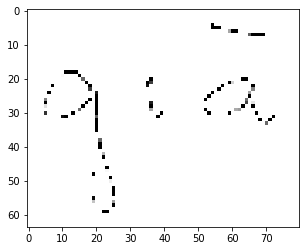

In [71]:
plt.imshow(imgs[0].squeeze().permute(1,2,0))

In [72]:
targets.size()

torch.Size([5, 1, 1])

In [73]:
''.join([int2char[x.item()] for x in targets[:,0].squeeze()])

'<start>già<end>'

In [74]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    imgs = imgs.to(device)
    img_features = encoder(imgs)
    targets_onehot = targets_onehot[1:].to(device)
    targets = targets[1:].to(device)
    lengths = lengths - 1
    start_input = torch.zeros(1,1,vocab_size).to(device)
    start_input[:,:,char2int[SOS_CHAR]] = 1
    outputs, weights = decoder.forward(img_features, torch.rand(10, 2), start_input, output_weight=True)

In [75]:
outputs.size()

torch.Size([10, 1, 150])

In [76]:
_, index = outputs.topk(1, -1)

In [77]:
index.size()

torch.Size([10, 1, 1])

In [78]:
predicts = index.squeeze(0).transpose(0, 1) # [B, T]
predicts

tensor([[[44],
         [46],
         [69],
         [10],
         [10],
         [10],
         [10],
         [10],
         [10],
         [10]]], device='cuda:0')

In [79]:
predicts_str = []
for predict in predicts:
    s = [int2char[x.item()] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])
predicts_str

[['g', 'i', 'à', '<end>']]

# Visualize a sample

In [34]:
len(weights)

1

In [35]:
weights[0].size()

torch.Size([20, 1, 1])

In [43]:
weights[0].cpu().numpy().squeeze()

array([5.9893460e-04, 8.1131264e-04, 4.6461646e-04, 4.8759789e-04,
       5.5234059e-04, 6.2370575e-03, 3.0256116e-03, 5.9357408e-04,
       5.2649225e-04, 5.5596547e-04, 9.5860755e-01, 9.8218704e-03,
       4.5209005e-03, 1.7970813e-03, 1.2069643e-03, 3.2492273e-03,
       5.7816878e-04, 1.0970802e-03, 3.0100215e-03, 2.2575874e-03],
      dtype=float32)

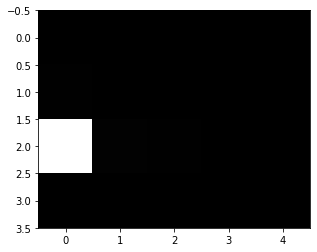

In [39]:
def plot_weight(weight):
    weight_img = weight.cpu().numpy().squeeze()
    weight_img = weight_img.reshape((4,5))
    plt.imshow(weight_img, cmap='gray')
plot_weight(weights[0])

In [26]:
sample_index = 1
sample_image, sample_predict, sample_weigth = imgs[sample_index], predicts_str[sample_index], weights[:, [sample_index]]
fig, axeses = plt.subplots(len(sample_predict), figsize=(15,15), sharex=True, sharey=True)

for i, axes in enumerate(axeses.ravel()):
    weight = weights[i].reshape(-1, config['batch_size'], img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
    weight_numpy = weight.cpu().numpy()[:,sample_index,:].squeeze()
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    
    img = sample_image.squeeze().permute(1,2,0).cpu().numpy()[:,:,0]
    
    alpha = 0.5
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.set_title(sample_predict[i])
    axes.imshow(blend, cmap='spring')
plt.plot();

IndexError: index 1 is out of bounds for dimension 0 with size 1

# Calc CER, WER on the test set

## CER

In [29]:
import editdistance as ed

In [30]:
log_test = open('./log_test.txt', 'w+')

In [31]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

# t = tqdm(test_loader)
t = test_loader
with torch.no_grad():
    for i, (imgs, targets, targets_onehot, lengths) in enumerate(t):
        print(f'[{i}]/[{len(t)}]', file=log_test)
        log_test.flush()
        batch_size = imgs.size(0)
        
        imgs = imgs.to(device)
        img_features = encoder(imgs)
        targets_onehot = targets_onehot[1:].to(device)
        targets = targets[1:].to(device)
        lengths = lengths - 1
        outputs = decoder.forward(img_features, targets_onehot, targets, lengths, char2int[PAD_CHAR])
        
        _, index = outputs.topk(1, -1)
        predicts = index.squeeze().transpose(0, 1) # [B, T]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x.item()] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for j in range(len(predicts_str)):
            CE += ed.distance(predicts_str[j], targets_str[j])
        total_characters += lengths.sum().item()
        
        for j in range(len(predicts_str)):
            if not np.array_equal(np.array(predicts_str[j]), np.array(targets_str[j])):
                WE += 1
                print(f'Batch {i} - sample {j}: "{predicts_str[j]}"/"{targets_str[j]}"')
        total_words += len(predicts_str)
        
#         t.update()

Batch 0 - sample 25: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 0 - sample 26: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 2 - sample 31: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 8 - sample 31: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 9 - sample 13: "['s', 's', 'n', '<end>']"/"['s', 'ẵ', 'n', '<end>']"
Batch 15 - sample 27: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 16 - sample 26: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 17 - sample 30: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 24 - sample 30: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 28 - sample 21: "['s', 's', 'n', '<end>']"/"['s', 'ẵ', 'n', '<end>']"
Batch 29 - sample 25: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 31 - sample 27: "['M', 'M', '<end>']"/"['M', 'ỹ', '<end>']"
Batch 39 - sample 22: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 39 - sample 28: "['k', 'k', '<end>']"/"['k', 'ỳ', '<end>']"
Batch 39 - sample 31: "['y', 'n', '<end>']"/"['Â', 'n', '<end

In [32]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER, file=log_test)
print('WER', WER, file=log_test)
log_test.flush()

In [33]:
log_test.close()

In [34]:
print(CE, total_characters, CER)

164 108614 0.0015099342626180786


In [35]:
print(WE, total_words, WER)

156 25115 0.0062114274338044995
